In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as an
import sklearn.metrics
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
#adata=sc.read(results_file_post)
#adata.uns['log1p'] = {"base":None}

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.3 anndata==0.10.7 umap==0.5.5 numpy==1.26.4 scipy==1.13.0 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.1 python-igraph==0.10.4 pynndescent==0.5.12


In [4]:
#%matplotlib inline

In [5]:
writeDir = "write/"

fileName = "luadMDA"

resultsFileQC = writeDir + fileName + '_QC.h5ad' 


In [6]:
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=150, fontsize=10, format='png')
sc.settings.figdir = "figures/" + fileName + "/"
figName = fileName

In [8]:
inDir = 'data/LUAD/mda'


In [26]:
pd.read_csv(f"{inDir}/mdaBarcodes.csv",index_col=0).iloc[:,0].values

array(['P1-T2_GCGCAGTCAAGGACTG', 'P1-T2_ACCGTAACAGTGGAGT',
       'P1-T2_CTTGGCTTCTACTTAC', ..., 'P8_T2pos_TGGCCAGCAACTTGAC',
       'P8_T2pos_TGGCGCATCAGCCTAA', 'P8_T2pos_TTCTTAGTCGTAGATC'],
      dtype=object)

In [25]:
pd.read_csv(f"{inDir}/mdaGenes.csv",index_col=0).iloc[:,0].values

array(['AL669831.5', 'LINC00115', 'FAM41C', ..., 'AL158042.1',
       'AP000962.1', 'H2BFS.1'], dtype=object)

In [27]:
pd.read_csv(f"{inDir}/mdaMeta.csv",index_col=0).loc[:,"celltype"].values

array(['malig', 'malig', 'malig', ..., 'airway_ClubandSecretory',
       'airway_ClubandSecretory', 'airway_ClubandSecretory'], dtype=object)

In [28]:
adata = sc.read_mtx(f"{inDir}/mdaLUADdata.mtx").T
adata.obs_names = pd.read_csv(f"{inDir}/mdaBarcodes.csv",index_col=0).iloc[:,0].values
adata.var_names = pd.read_csv(f"{inDir}/mdaGenes.csv",index_col=0).iloc[:,0].values
adata.obs["celltype"] = pd.read_csv(f"{inDir}/mdaMeta.csv",index_col=0).loc[:,"celltype"].values

In [29]:
adata.var_names_make_unique()
adata.obs_names_make_unique()
adata

AnnData object with n_obs × n_vars = 245427 × 26828
    obs: 'celltype'

# Start QC
investigate highest expressed genes

normalizing counts per cell
    finished (0:00:02)


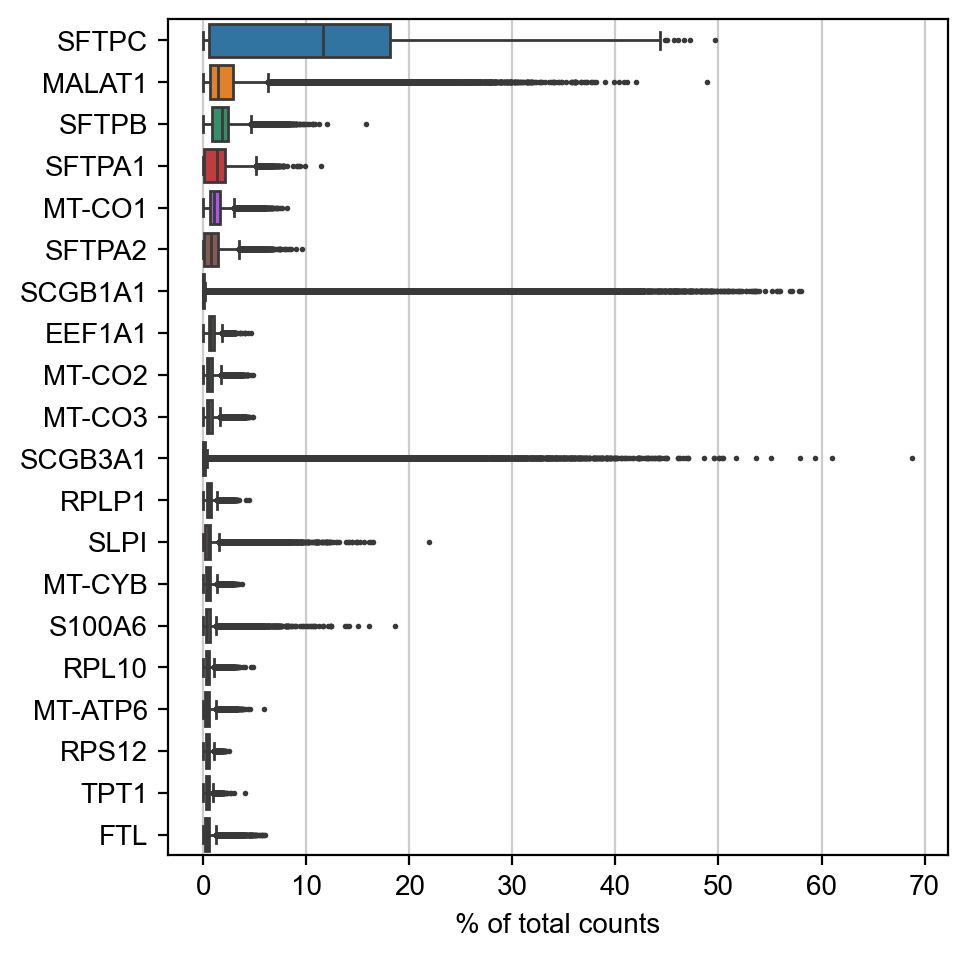

In [30]:
sc.pl.highest_expr_genes(adata, n_top=20)

/tmp/ipykernel_3601859/1246121538.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


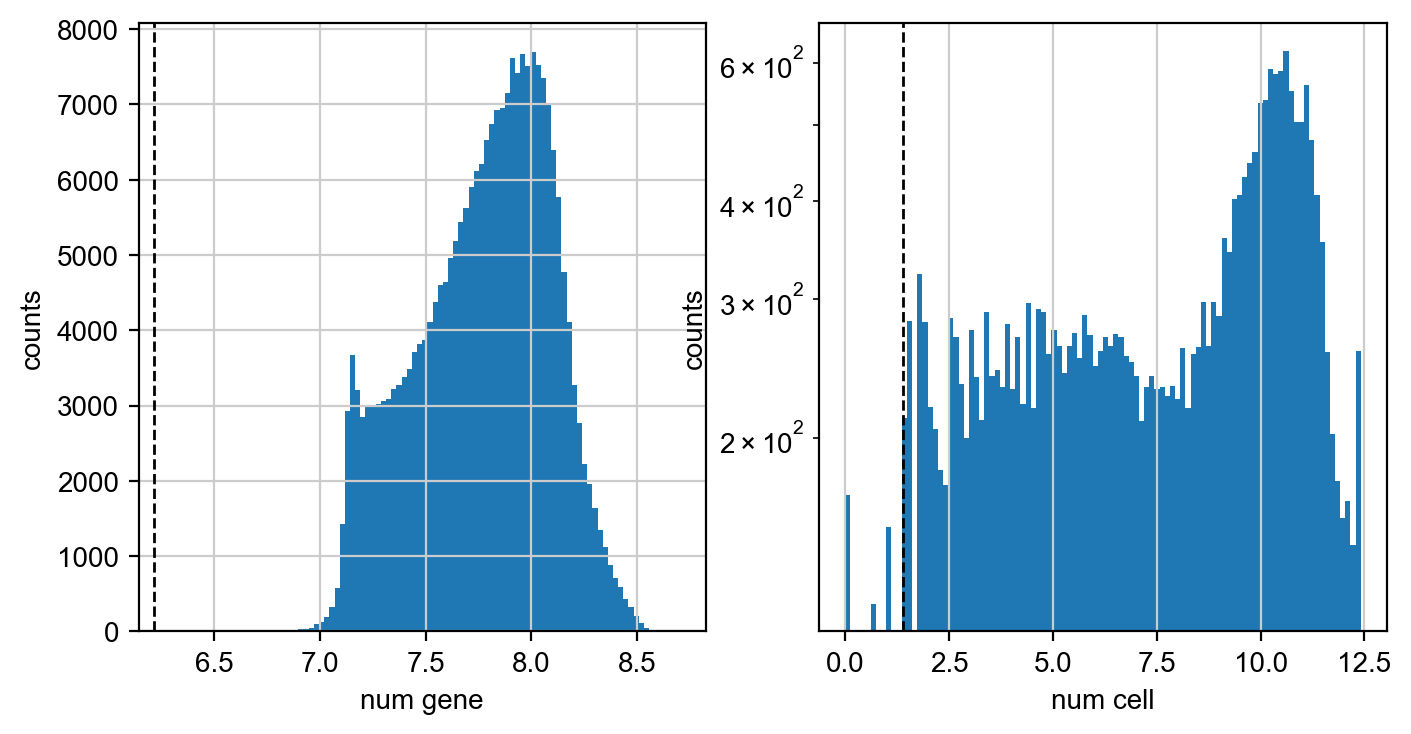

In [36]:
valX = adata.X>0
minGenes=500
minCells=3

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

numCellwExp = valX.sum(axis=1)
axs[0].hist(np.log(numCellwExp), bins=100)#, log=True)
axs[0].axvline(np.log(minGenes), color='k', linestyle='dashed', linewidth=1)
axs[0].set_xlabel('num gene')
axs[0].set_ylabel('counts')

numGeneswExp = valX.sum(axis=0).T
axs[1].hist(np.log(numGeneswExp+1), bins=100, log=True)
axs[1].axvline(np.log(minCells+1), color='k', linestyle='dashed', linewidth=1)
#axs[0,1].axvline(np.log(600), color='k', linestyle='dashed', linewidth=1)
#axs[0,1].axvline(np.log(4000), color='k', linestyle='dashed', linewidth=1)
#axs[0,1].set_title('Gene means counts')
axs[1].set_xlabel('num cell')
axs[1].set_ylabel('counts')

fig.show()

In [37]:
sc.pp.filter_cells(adata, min_genes = minGenes)
sc.pp.filter_genes(adata, min_cells = minCells)

filtered out 446 genes that are detected in less than 3 cells


In [38]:
adata = adata[:,np.logical_not(adata.var_names=="MALAT1")]
adata

View of AnnData object with n_obs × n_vars = 245427 × 26381
    obs: 'celltype', 'n_genes'
    var: 'n_cells'

## Mito QC

In [40]:
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], log1p = False, inplace=True)

/tmp/ipykernel_3601859/2933791377.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var_names.str.startswith('MT-')


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


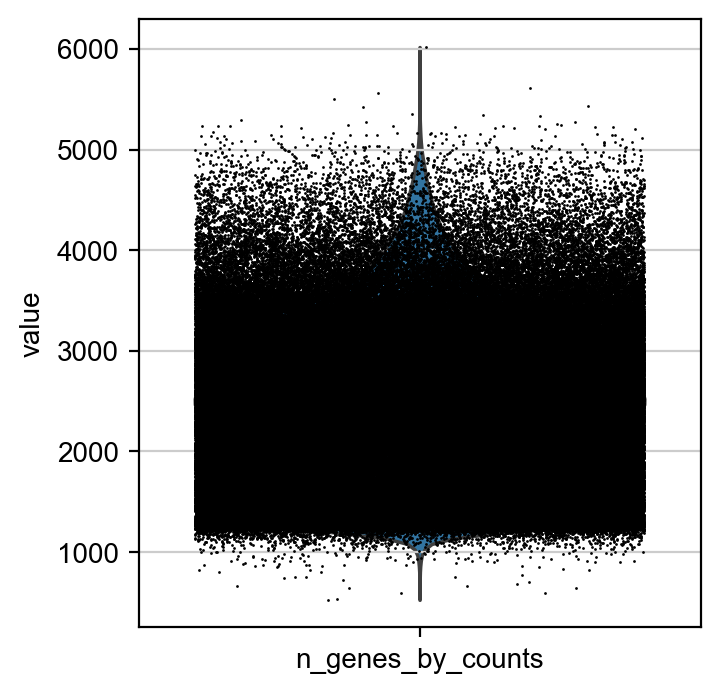

/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


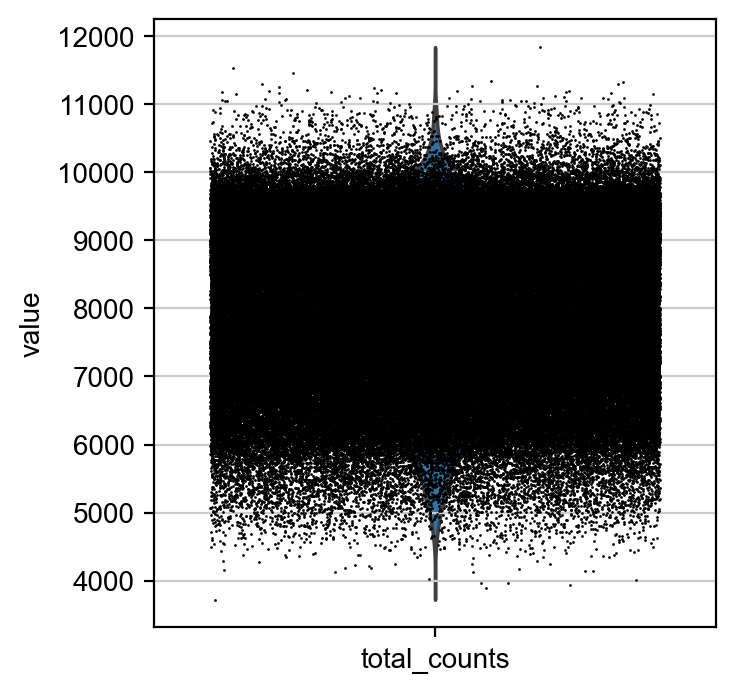

/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


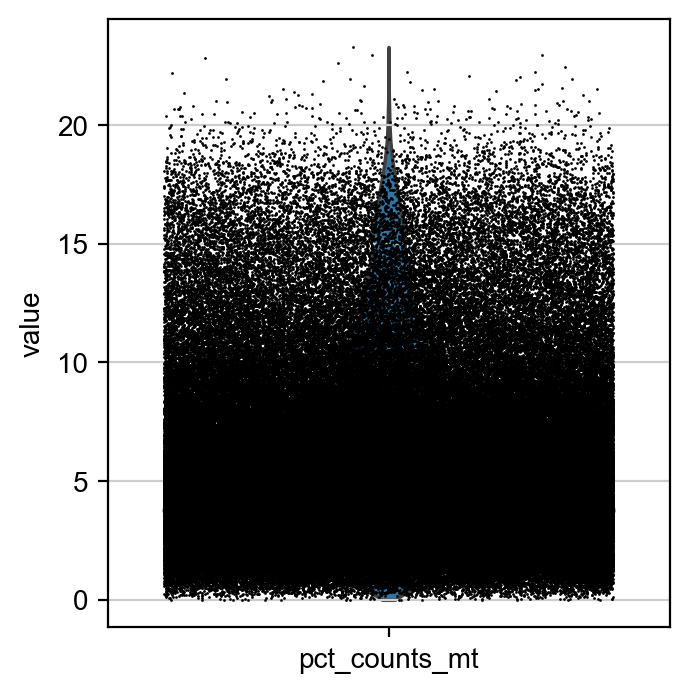

In [41]:
sc.pl.violin(adata, ['n_genes_by_counts'], jitter=0.4)
sc.pl.violin(adata, ['total_counts'], jitter=0.4)
sc.pl.violin(adata, ['pct_counts_mt'], jitter=0.4)

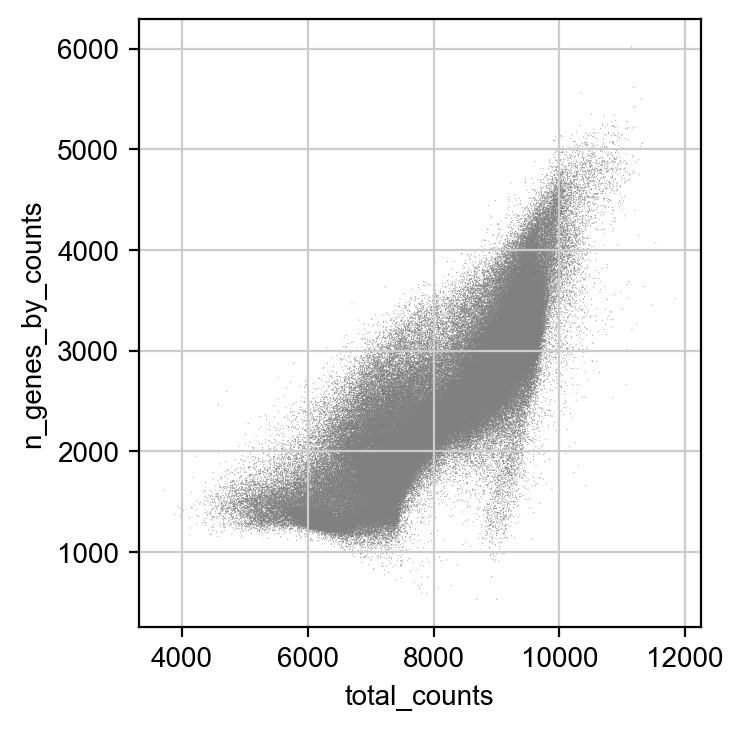

In [42]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

remove cells that have too much mito or could be doublets

In [43]:
adata = adata[adata.obs.n_genes_by_counts < 5000, :]
adata = adata[adata.obs.total_counts < 11000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]

/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


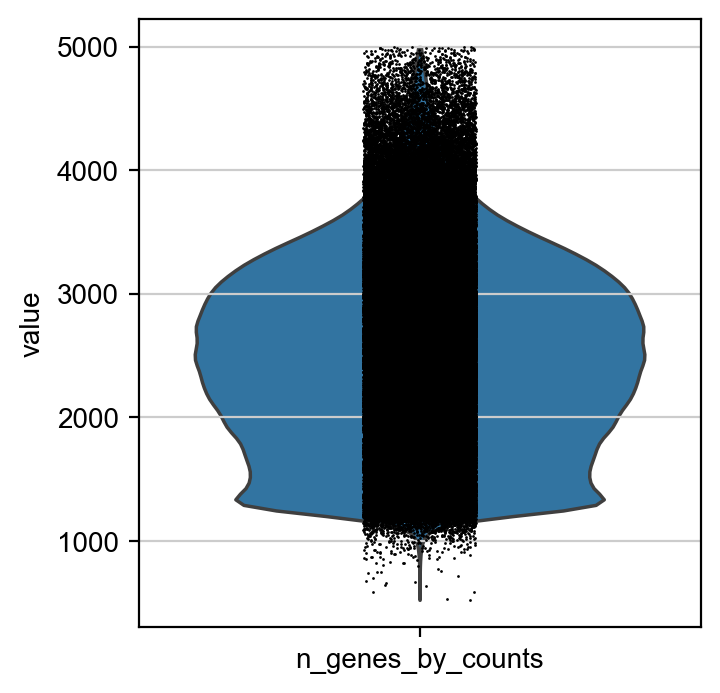

/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


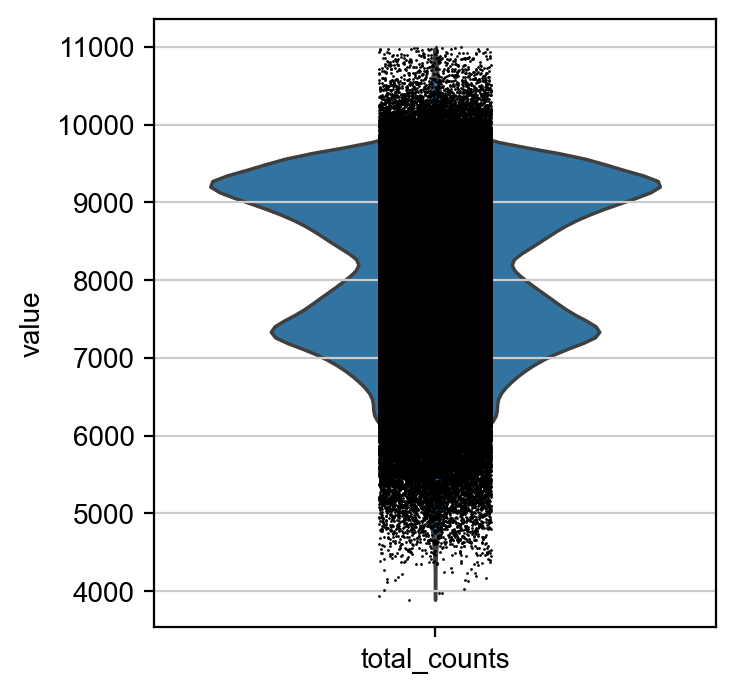

In [44]:
sc.pl.violin(adata, ['n_genes_by_counts'])
sc.pl.violin(adata, ['total_counts'])

save post QC scanpy

In [45]:
adata

View of AnnData object with n_obs × n_vars = 245091 × 26381
    obs: 'celltype', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [47]:
resultsFileQC

'write/luadMDA_QC.h5ad'

In [48]:
adata.write(resultsFileQC)